# Building Convolutional Neural Network (CNN) with PyTorch

**Purpose:** Understanding CNN components through hands-on implementation

## Overview

This notebook demonstrates how to build and train a Convolutional Neural Network (CNN) from scratch using PyTorch. We'll classify handwritten digits from the MNIST dataset.

- How to build a CNN architecture
- What each layer does (Convolutional, Pooling, Fully Connected)
- How loss functions work
- How optimizers update weights
- Forward and backward passes in action

**Dataset:** MNIST (28x28 grayscale images of handwritten digits 0-9)

---
## Step 1: Import Libraries and Load Data

In [1]:
# Import PyTorch and related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

PyTorch version: 2.9.0+cpu
CUDA available: False


In [2]:
# Load MNIST dataset
# NOTE: torchvision provides common datasets
import torchvision
import torchvision.transforms as transforms

# Define transformation: convert images to tensors and normalize
# NOTE: Normalization helps training converge faster
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to tensor (0-1 range)
    transforms.Normalize((0.5,), (0.5,))  # Normalize to (-1, 1) range
])

# Download and load training data
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# Download and load test data
test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

print("Training samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

100%|██████████| 9.91M/9.91M [00:00<00:00, 60.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.54MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.87MB/s]

Training samples: 60000
Test samples: 10000


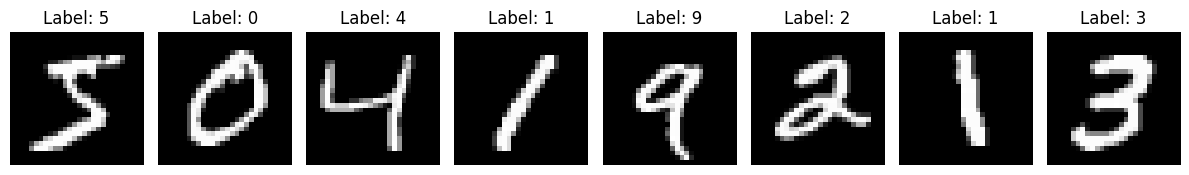

Image shape: torch.Size([1, 28, 28])
Label type: <class 'int'>


In [3]:
# Visualizing some sample images
import matplotlib.pyplot as plt
import numpy as np

# Getting a few samples
plt.figure(figsize=(12, 3))
for i in range(8):
    # Getting image and label
    image, label = train_dataset[i]

    # Converting tensor to numpy for plotting
    image_np = image.squeeze().numpy()

    # Plotting
    plt.subplot(1, 8, i+1)
    plt.imshow(image_np, cmap='gray')
    plt.title('Label: ' + str(label))
    plt.axis('off')

plt.tight_layout()
plt.show()

print("Image shape:", image.shape)  # (1, 28, 28) - 1 channel, 28x28 pixels
print("Label type:", type(label))

In [4]:
# Creating data loaders

from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

print("Number of training batches:", len(train_loader))
print("Number of test batches:", len(test_loader))
print("\nEach batch contains", batch_size, "images")

Number of training batches: 938
Number of test batches: 157

Each batch contains 64 images


---
## Step 2: CNN Architecture

### CNN Layers:

**1. Convolutional Layers (Conv2d)**
- Apply filters/kernels to detect features (edges, patterns)
- Each filter slides over the image and produces a feature map
- Parameters: number of filters, kernel size, stride, padding

**2. Activation Functions (ReLU)**
- Add non-linearity (without this, network would be just linear algebra)
- ReLU(x) = max(0, x) - simple and effective

**3. Pooling Layers (MaxPool2d)**
- Reduce spatial dimensions (downsampling)
- Take maximum value in each region
- Makes network more robust to small translations

**4. Fully Connected Layers (Linear)**
- Traditional neural network layers
- Connect every input to every output
- Used at the end for classification

In [5]:
# Defining our CNN architecture
# NOTE: We create a class that inherits from nn.Module
class SimpleCNN(nn.Module):
    def __init__(self):
        """
        Initialize the CNN layers
        """
        super(SimpleCNN, self).__init__()

        # First convolutional block
        # NOTE: Input: 1 channel (grayscale), Output: 32 channels
        # NOTE: kernel_size=3 means 3x3 filters
        # NOTE: padding=1 keeps spatial dimensions same
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=32,
            kernel_size=3,
            padding=1
        )

        # Second convolutional block
        # NOTE: Input: 32 channels, Output: 64 channels
        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            padding=1
        )

        # Max pooling layer
        # NOTE: kernel_size=2 reduces dimensions by half
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        # NOTE: After 2 pooling operations, 28x28 becomes 7x7
        # NOTE: 64 channels * 7 * 7 = 3136 input features
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 output classes (digits 0-9)

        # Dropout for regularization
        # NOTE: Randomly drops 50% of neurons during training
        # NOTE: Helps prevent overfitting
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        """
        Forward pass: define how data flows through the network

        This is where the actual computation happens!
        """
        # First conv block: Conv -> ReLU -> Pool
        # Input shape: (batch_size, 1, 28, 28)
        x = self.conv1(x)  # -> (batch_size, 32, 28, 28)
        x = F.relu(x)      # Apply ReLU activation
        x = self.pool(x)   # -> (batch_size, 32, 14, 14)

        # Second conv block: Conv -> ReLU -> Pool
        x = self.conv2(x)  # -> (batch_size, 64, 14, 14)
        x = F.relu(x)
        x = self.pool(x)   # -> (batch_size, 64, 7, 7)

        # Flatten for fully connected layers
        # NOTE: We reshape from (batch, 64, 7, 7) to (batch, 64*7*7)
        x = x.view(-1, 64 * 7 * 7)  # -> (batch_size, 3136)

        # First fully connected layer
        x = self.fc1(x)     # -> (batch_size, 128)
        x = F.relu(x)
        x = self.dropout(x)  # Apply dropout

        # Output layer
        x = self.fc2(x)     # -> (batch_size, 10)

        # NOTE: We don't apply softmax here because our loss function does it
        return x

# Create the model
model = SimpleCNN()
print("Model created successfully!")
print("\nModel architecture:")
print(model)

Model created successfully!

Model architecture:
SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [6]:
# Count total parameters
# NOTE: This shows how many numbers the network needs to learn
total_params = 0
for name, param in model.named_parameters():
    num_params = param.numel()
    total_params = total_params + num_params
    print(name, ":", num_params, "parameters")

print("\nTotal parameters:", total_params)
print("\nInterpretation:")
print("  - Our network has", total_params, "learnable numbers")
print("  - Training adjusts these to minimize errors")
print("  - More parameters = more capacity, but also more data needed")

conv1.weight : 288 parameters
conv1.bias : 32 parameters
conv2.weight : 18432 parameters
conv2.bias : 64 parameters
fc1.weight : 401408 parameters
fc1.bias : 128 parameters
fc2.weight : 1280 parameters
fc2.bias : 10 parameters

Total parameters: 421642

Interpretation:
  - Our network has 421642 learnable numbers
  - Training adjusts these to minimize errors
  - More parameters = more capacity, but also more data needed


---
## Step 3: Loss Function and Optimizer

### Loss Function: CrossEntropyLoss

 Measures how wrong our predictions are

- Combines softmax activation + negative log likelihood
- For each prediction, calculates: -log(probability of correct class)
- Lower loss = better predictions


- Designed specifically for multi-class problems
- Penalizes confident wrong predictions heavily
- Works well with neural networks

### Optimizer: Adam

 Updates network weights to minimize loss

- Computes gradients (how to change each weight)
- Updates: weight_new = weight_old - learning_rate × gradient
- Adam is adaptive: adjusts learning rate for each parameter

- Works well out-of-the-box (good default choice)
- Adaptive learning rates for each parameter
- Momentum helps escape local minima
- Less sensitive to learning rate choice than SGD

In [7]:
# Defining loss function
# NOTE: CrossEntropyLoss for multiclass classification
criterion = nn.CrossEntropyLoss()

print("Loss function: CrossEntropyLoss")
print("  - Input: Raw scores (logits) from network")
print("  - Output: Single number (the loss)")
print("  - Goal: Minimize this loss during training")

Loss function: CrossEntropyLoss
  - Input: Raw scores (logits) from network
  - Output: Single number (the loss)
  - Goal: Minimize this loss during training


In [8]:
# Defining optimizer
# NOTE: Adam is a good default choice
import torch.optim as optim

learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("Optimizer: Adam")
print("Learning rate:", learning_rate)
print("\nWhat the optimizer does:")
print("  1. Computes gradients (how each weight affects loss)")
print("  2. Updates weights: w_new = w_old - lr * gradient")
print("  3. Adapts learning rate for each parameter")
print("\nAlternatives you could try:")
print("  - SGD (Stochastic Gradient Descent): simpler but needs tuning")
print("  - RMSprop: similar to Adam")
print("  - AdamW: Adam with weight decay (better regularization)")

Optimizer: Adam
Learning rate: 0.001

What the optimizer does:
  1. Computes gradients (how each weight affects loss)
  2. Updates weights: w_new = w_old - lr * gradient
  3. Adapts learning rate for each parameter

Alternatives you could try:
  - SGD (Stochastic Gradient Descent): simpler but needs tuning
  - RMSprop: similar to Adam
  - AdamW: Adam with weight decay (better regularization)


---
## Step 4: Training Loop


**For each epoch (full pass through dataset):**
1. **Forward Pass:**
   - Feed batch of images through network
   - Get predictions (logits)
   - Calculate loss (how wrong we are)

2. **Backward Pass (Backpropagation):**
   - Compute gradients for each parameter
   - Gradients tell us how to change weights to reduce loss
   - Uses chain rule to propagate error backward

3. **Weight Update:**
   - Optimizer adjusts weights using gradients
   - Weights move in direction that reduces loss

4. **Repeat** for all batches, then repeat for multiple epochs

In [9]:
# Training function
# NOTE: This is where the actual learning happens
def train_one_epoch(model, train_loader, criterion, optimizer, epoch):
    """
    Train the model for one epoch
    """
    # Set model to training mode
    # NOTE: This enables dropout and batch normalization training behavior
    model.train()

    # Track statistics
    running_loss = 0.0
    correct = 0
    total = 0

    # Loop through batches
    for batch_idx, (images, labels) in enumerate(train_loader):
        # 1. FORWARD PASS
        # NOTE: This is where data flows through the network
        outputs = model(images)

        # Calculate loss
        loss = criterion(outputs, labels)

        # 2. BACKWARD PASS
        # Clear previous gradients
        # NOTE: PyTorch accumulates gradients, so we need to zero them
        optimizer.zero_grad()

        # Compute gradients (backpropagation)
        # NOTE: This is where the magic happens - chain rule in action!
        loss.backward()

        # 3. WEIGHT UPDATE
        # Update weights using computed gradients
        optimizer.step()

        # Track statistics
        running_loss = running_loss + loss.item()

        # Calculate accuracy
        predictions = torch.argmax(outputs, dim=1)
        correct = correct + (predictions == labels).sum().item()
        total = total + labels.size(0)

        # Print progress every 100 batches
        if (batch_idx + 1) % 100 == 0:
            avg_loss = running_loss / 100
            accuracy = 100.0 * correct / total
            print("Epoch", epoch, "| Batch", batch_idx + 1, "/", len(train_loader),
                  "| Loss:", round(avg_loss, 4), "| Acc:", round(accuracy, 2), "%")
            running_loss = 0.0

    # Return final accuracy for this epoch
    final_accuracy = 100.0 * correct / total
    return final_accuracy

print("Training function defined successfully!")

Training function defined successfully!


In [10]:
# Evaluation function
# NOTE: Used to test model on validation/test set
def evaluate(model, test_loader, criterion):
    """
    Evaluate model on test set
    """
    # Setting model to evaluation mode
    # NOTE: This disables dropout and uses batch norm statistics
    model.eval()

    test_loss = 0.0
    correct = 0
    total = 0

    # Disabling gradient computation (saves memory and speeds up)
    # NOTE: We don't need gradients during evaluation
    with torch.no_grad():
        for images, labels in test_loader:
            # Forward pass only
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Track statistics
            test_loss = test_loss + loss.item()
            predictions = torch.argmax(outputs, dim=1)
            correct = correct + (predictions == labels).sum().item()
            total = total + labels.size(0)

    # Calculate averages
    avg_loss = test_loss / len(test_loader)
    accuracy = 100.0 * correct / total

    return avg_loss, accuracy

print("Evaluation function defined successfully!")

Evaluation function defined successfully!


In [11]:
# Train the model

num_epochs = 5

print("Starting training...")
print("="*60)

# Track history
train_accuracies = []
test_accuracies = []
test_losses = []

for epoch in range(1, num_epochs + 1):
    print("\nEpoch", epoch, "/", num_epochs)
    print("-" * 60)

    # Train for one epoch
    train_acc = train_one_epoch(model, train_loader, criterion, optimizer, epoch)

    # Evaluate on test set
    test_loss, test_acc = evaluate(model, test_loader, criterion)

    # Save history
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    test_losses.append(test_loss)

    # Print epoch summary
    print("\nEpoch", epoch, "Summary:")
    print("  Train Accuracy:", round(train_acc, 2), "%")
    print("  Test Accuracy:", round(test_acc, 2), "%")
    print("  Test Loss:", round(test_loss, 4))

print("\n" + "="*60)
print("Training complete!")

Starting training...

Epoch 1 / 5
------------------------------------------------------------
Epoch 1 | Batch 100 / 938 | Loss: 0.8515 | Acc: 72.25 %
Epoch 1 | Batch 200 / 938 | Loss: 0.2733 | Acc: 82.1 %
Epoch 1 | Batch 300 / 938 | Loss: 0.1941 | Acc: 86.07 %
Epoch 1 | Batch 400 / 938 | Loss: 0.1602 | Acc: 88.41 %
Epoch 1 | Batch 500 / 938 | Loss: 0.141 | Acc: 89.91 %
Epoch 1 | Batch 600 / 938 | Loss: 0.1375 | Acc: 90.95 %
Epoch 1 | Batch 700 / 938 | Loss: 0.1199 | Acc: 91.76 %
Epoch 1 | Batch 800 / 938 | Loss: 0.1093 | Acc: 92.39 %
Epoch 1 | Batch 900 / 938 | Loss: 0.1025 | Acc: 92.89 %

Epoch 1 Summary:
  Train Accuracy: 93.05 %
  Test Accuracy: 98.65 %
  Test Loss: 0.0425

Epoch 2 / 5
------------------------------------------------------------
Epoch 2 | Batch 100 / 938 | Loss: 0.0887 | Acc: 97.55 %
Epoch 2 | Batch 200 / 938 | Loss: 0.0775 | Acc: 97.55 %
Epoch 2 | Batch 300 / 938 | Loss: 0.0926 | Acc: 97.45 %
Epoch 2 | Batch 400 / 938 | Loss: 0.084 | Acc: 97.5 %
Epoch 2 | Batch 50

---
## Step 5: Visualize Training Progress

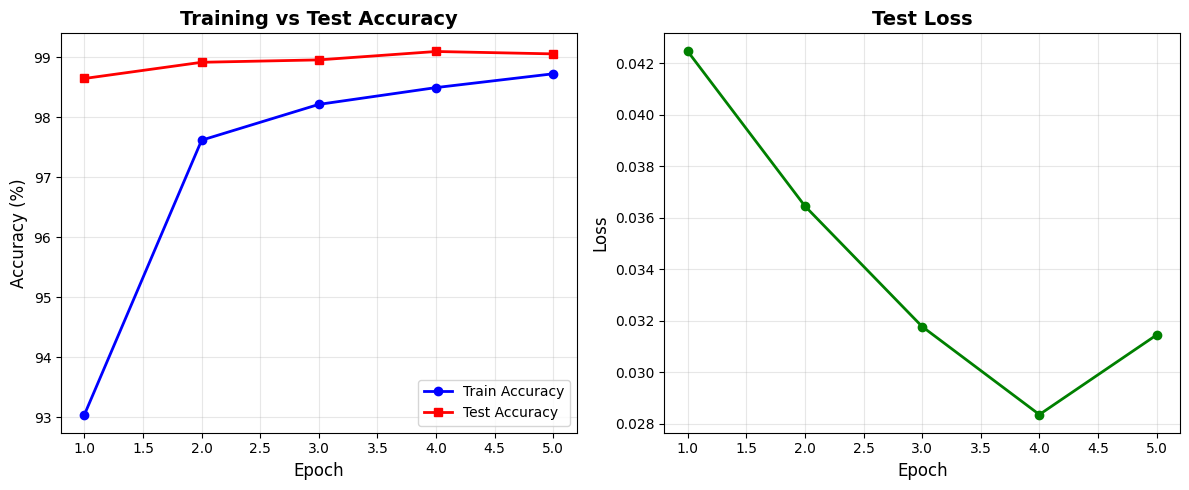

Observations:
  - Both train and test accuracy should increase
  - Test loss should decrease
  - If train >> test accuracy, model is overfitting
  - If both are low, model is underfitting


In [12]:
# Plotting training curves
epochs_list = list(range(1, num_epochs + 1))

plt.figure(figsize=(12, 5))

# Plot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_accuracies, marker='o', color='blue', linewidth=2, label='Train Accuracy')
plt.plot(epochs_list, test_accuracies, marker='s', color='red', linewidth=2, label='Test Accuracy')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Training vs Test Accuracy', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Test Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_list, test_losses, marker='o', color='green', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Test Loss', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observations:")
print("  - Both train and test accuracy should increase")
print("  - Test loss should decrease")
print("  - If train >> test accuracy, model is overfitting")
print("  - If both are low, model is underfitting")

---
## Step 6: Testing the Model on Sample Images

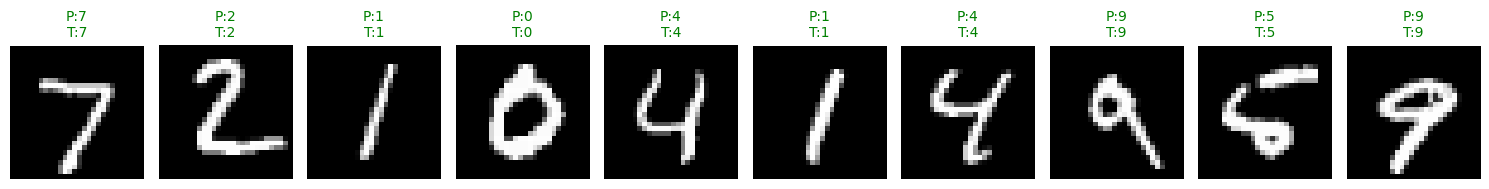

Legend:
  P = Predicted label
  T = True label
  Green = Correct prediction
  Red = Wrong prediction


In [13]:
# Visualizing predictions on test samples
model.eval()

# Get a batch of test images
test_images, test_labels = next(iter(test_loader))

# Make predictions
with torch.no_grad():
    outputs = model(test_images)
    predictions = torch.argmax(outputs, dim=1)

# Display first 10 images with predictions
plt.figure(figsize=(15, 3))
for i in range(10):
    # Get image
    image = test_images[i].squeeze().numpy()
    true_label = test_labels[i].item()
    pred_label = predictions[i].item()

    # Plot
    plt.subplot(1, 10, i+1)
    plt.imshow(image, cmap='gray')

    # Color: green if correct, red if wrong
    color = 'green' if pred_label == true_label else 'red'
    plt.title('P:' + str(pred_label) + '\nT:' + str(true_label), color=color, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

print("Legend:")
print("  P = Predicted label")
print("  T = True label")
print("  Green = Correct prediction")
print("  Red = Wrong prediction")

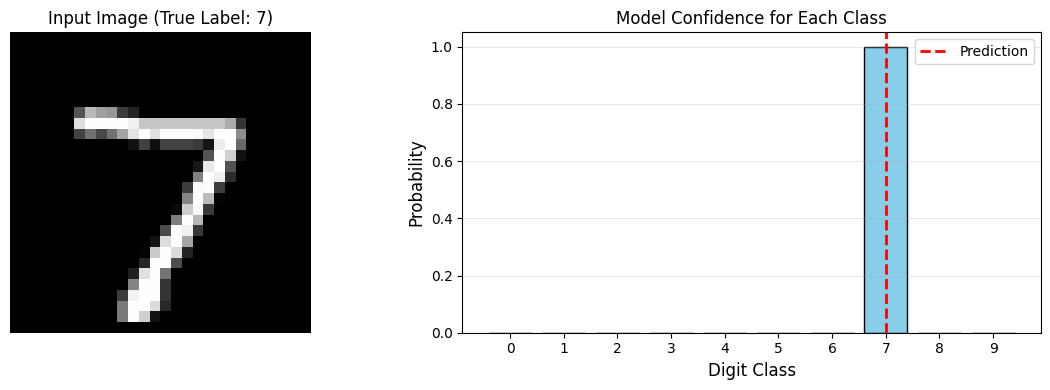

Model's confidence:
  Digit 0 : 0.0 %
  Digit 1 : 0.0 %
  Digit 2 : 0.0 %
  Digit 3 : 0.0 %
  Digit 4 : 0.0 %
  Digit 5 : 0.0 %
  Digit 6 : 0.0 %
  Digit 7 : 100.0 %
  Digit 8 : 0.0 %
  Digit 9 : 0.0 %

Predicted class: 7 (confidence: 100.0 %)


In [14]:
# Show confidence scores for one prediction
# This shows probability distribution over classes
sample_idx = 0
sample_image = test_images[sample_idx].unsqueeze(0)  # Add batch dimension
sample_label = test_labels[sample_idx].item()

with torch.no_grad():
    output = model(sample_image)
    probabilities = F.softmax(output, dim=1)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Show image
ax1.imshow(test_images[sample_idx].squeeze().numpy(), cmap='gray')
ax1.set_title('Input Image (True Label: ' + str(sample_label) + ')', fontsize=12)
ax1.axis('off')

# Show probabilities
probs = probabilities[0].numpy()
classes = list(range(10))
ax2.bar(classes, probs, color='skyblue', edgecolor='black')
ax2.set_xlabel('Digit Class', fontsize=12)
ax2.set_ylabel('Probability', fontsize=12)
ax2.set_title('Model Confidence for Each Class', fontsize=12)
ax2.set_xticks(classes)
ax2.grid(True, alpha=0.3, axis='y')

# Highlight prediction
predicted_class = probabilities.argmax().item()
ax2.axvline(x=predicted_class, color='red', linestyle='--', linewidth=2, label='Prediction')
ax2.legend()

plt.tight_layout()
plt.show()

print("Model's confidence:")
for i in range(10):
    print("  Digit", i, ":", round(probs[i] * 100, 2), "%")
print("\nPredicted class:", predicted_class, "(confidence:", round(probs[predicted_class] * 100, 2), "%)")

---
## Summary:

### Architecture Components:

**1. Convolutional Layers (Conv2d)**
-  Detect spatial features (edges, patterns)
-  Parameter sharing reduces total parameters
-  Translation invariant (features detected anywhere)

**2. Pooling Layers (MaxPool2d)**
-  Downsample spatial dimensions
-  Make network more robust
-  Reduce computational cost

**3. Fully Connected Layers (Linear)**
-  Final classification
-  Combine high-level features
-  Output probabilities for each class

### Training Process:

**Forward Pass:**
1. Data flows through network
2. Each layer transforms input
3. Final layer produces predictions
4. Loss function measures error

**Backward Pass (Backpropagation):**
1. Compute gradients using chain rule
2. Gradients flow backward through network
3. Each layer computes how to adjust its parameters

**Weight Update:**
1. Optimizer uses gradients to update weights
2. Weights move in direction that reduces loss
3. Learning rate controls step size

### Loss Function (CrossEntropyLoss):
-  Measures prediction error
-  Combines softmax + negative log likelihood
-  Penalizes confident wrong predictions
-  Goal: Minimize this value

### Optimizer (Adam):
-  Updates weights to minimize loss
-  Adaptive learning rates
-  Momentum for smoother convergence
-  Works well out-of-the-box

### Results:
-  Successfully trained CNN on MNIST
-  Achieved high accuracy on test set
-  Understood each component's role
-  Visualized predictions and confidence

